# Testing the models

In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Check Tensorflow version
print('Tensorflow version: ',tf.__version__)

Tensorflow version:  2.11.0


## Load the test data

In [3]:
def process_image_gender(path_gender, label):
    # Desired size
    size = 250
    path, gender = path_gender
    # Get the image
    img = tf.io.read_file(path)
    # Decode the PNG
    img = tf.image.decode_png(img)
    # Resize image
    img = tf.image.resize(img, (size, size))
    # Reshape image (this is not necessary but I do it so that I don't need to be modifying the shape in the input layer)
    img = tf.reshape(img, [size, size, 1])
    # Cast image to float32
    img = tf.cast(img, tf.float32)
    # Normalize image
    img = img/255.0

    return (img, gender), label
def process_image(path, label):
    # Desired size
    size = 250
    # Get the image
    img = tf.io.read_file(path)
    # Decode the PNG
    img = tf.image.decode_png(img)
    # Resize image
    img = tf.image.resize(img, (size, size))
    # Reshape image (this is not necessary but I do it so that I don't need to be modifying the shape in the input layer)
    img = tf.reshape(img, [size, size, 1])
    # Cast image to float32
    img = tf.cast(img, tf.float32)
    # Normalize image
    img = img/255.0

    return img, label
def get_paths_n_labels(csv_path, images_folder_path, id_col, label_col):
    df = pd.read_csv(csv_path)
    paths = [images_folder_path + '/' + str(id) + '.png' for id in df[id_col].tolist()]
    labels = df[label_col].tolist()
    return paths, labels
def get_data(csv_path, images_folder_path, id_col, label_col, gender_col):
    df = pd.read_csv(csv_path)
    paths = [images_folder_path + '/' + str(id) + '.png' for id in df[id_col].tolist()]
    labels = df[label_col].tolist()
    gender = [0 if (str(g)=="False" or str(g)=="FALSE" or str(g)=="F") else 1 for g in df[gender_col].tolist()] # male 1, female 0
    return paths, labels, gender

In [4]:
# original_r250p
otest_paths, otest_labels, otest_gender = get_data(
                                                csv_path='./data/pre_processed/test/test.csv',
                                                images_folder_path='./data/pre_processed/test/{}'.format('original_r250p'),
                                                id_col='Case ID',
                                                label_col='Ground truth bone age (months)',
                                                gender_col='Sex')
# Without gender
test_dataset_orig = tf.data.Dataset.from_tensor_slices((otest_paths,otest_labels)).map(process_image).batch(32)
# With gender
test_dataset_orig_gender = tf.data.Dataset.from_tensor_slices(((otest_paths,otest_gender),otest_labels)).map(process_image_gender).batch(32)

In [5]:
# preprocessed_r250p
ptest_paths, ptest_labels, ptest_gender = get_data(
                                                csv_path='./data/pre_processed/test/test.csv',
                                                images_folder_path='./data/pre_processed/test/{}'.format('preprocessed_r250p'),
                                                id_col='Case ID',
                                                label_col='Ground truth bone age (months)',
                                                gender_col='Sex')
# Without gender
test_dataset_preproc = tf.data.Dataset.from_tensor_slices((ptest_paths,ptest_labels)).map(process_image).batch(32)
# With gender
test_dataset_preproc_gender = tf.data.Dataset.from_tensor_slices(((ptest_paths,ptest_gender),ptest_labels)).map(process_image_gender).batch(32)

## Load the models

In [6]:
# Load the models with gender
inceptionv4_gender_orig = tf.keras.models.load_model('./models/inceptionv4_gender__original_r250p_1676203916.h5')
inceptionv4_gender_preproc = tf.keras.models.load_model('./models/inceptionv4_gender__preprocessed_r250p_1676244085.h5')
vgg6_gender_orig = tf.keras.models.load_model('./models/vgg_gender_original_r250p_1676150023.h5')
vgg6_gender_preproc = tf.keras.models.load_model('./models/vgg_gender_preprocessed_r250p_1676154512.h5')

In [7]:
# Load the models without gender
inceptionv4_orig = tf.keras.models.load_model('./models/inceptionv4_original_r250p_1676207504.h5')
inceptionv4_preproc = tf.keras.models.load_model('./models/inceptionv4_preprocessed_r250p_1676249796.h5')
vgg6_orig = tf.keras.models.load_model('./models/vgg_original_r250p_1676147625.h5')
vgg6_preproc = tf.keras.models.load_model('./models/vgg_preprocessed_r250p_1676153487.h5')

## Evaluate the models

In [8]:
# Evaluate models
def evaluate_model_gender(model, dataset):
    p_test = model.predict(dataset).reshape(-1)
    y_test = np.array([label.numpy() for (img,gender), label in dataset.unbatch()])
    mae = np.mean(np.abs(np.subtract(y_test, p_test)))
    print("Mean absolute error: "+str(mae))
def evaluate_model(model, dataset):
    p_test = model.predict(dataset).reshape(-1)
    y_test = np.array([label.numpy() for img, label in dataset.unbatch()])
    mae = np.mean(np.abs(np.subtract(y_test, p_test)))
    print("Mean absolute error: "+str(mae))

### VGG-6

w/o Gender


In [9]:
# original_r250p
evaluate_model(vgg6_orig,test_dataset_orig)

7/7 [==============================] - 2s 175ms/step
Mean absolute error: 16.205986


In [10]:
# preprocessed_r250p
evaluate_model(vgg6_preproc,test_dataset_preproc)

7/7 [==============================] - 1s 168ms/step
Mean absolute error: 14.109846


w/ Gender

In [11]:
# original_r250p
evaluate_model_gender(vgg6_gender_orig,test_dataset_orig_gender)

7/7 [==============================] - 1s 174ms/step
Mean absolute error: 15.715346


In [12]:
# preprocessed_r250p
evaluate_model_gender(vgg6_gender_preproc,test_dataset_preproc_gender)

7/7 [==============================] - 1s 171ms/step
Mean absolute error: 9.180414


### Inception-V4

w/o Gender


In [13]:
# original_r250p
evaluate_model(inceptionv4_orig,test_dataset_orig)

7/7 [==============================] - 22s 3s/step
Mean absolute error: 10.930362


In [14]:
# preprocessed_r250p
evaluate_model(inceptionv4_preproc,test_dataset_preproc)

7/7 [==============================] - 22s 3s/step
Mean absolute error: 10.53585


w/ Gender

In [15]:
# original_r250p
evaluate_model_gender(inceptionv4_gender_orig,test_dataset_orig_gender)

7/7 [==============================] - 22s 3s/step
Mean absolute error: 8.053529


In [16]:
# preprocessed_r250p
evaluate_model_gender(inceptionv4_gender_preproc,test_dataset_preproc_gender)

7/7 [==============================] - 23s 3s/step
Mean absolute error: 7.4948206


# Demo


In [89]:
#p_test = inceptionv4_gender_preproc.predict(test_dataset_preproc_gender).reshape(-1)
p_test = vgg6_gender_preproc.predict(test_dataset_preproc_gender).reshape(-1)

7/7 [==============================] - 2s 251ms/step


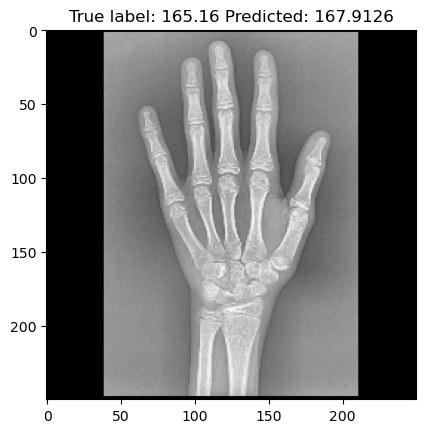

In [93]:
# Show some classification examples
y_test = np.array([label.numpy() for (img,gender), label in test_dataset_preproc_gender.unbatch()])
x_test = np.array([img.numpy() for (img,gender), label in test_dataset_preproc_gender.unbatch()])
difference = np.abs(np.subtract(y_test, p_test))
mae = np.mean(difference)
misclassified_idx = np.where(difference<7)
i = np.random.choice(misclassified_idx[0])
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], p_test[i]));